In [1]:
%%time
%matplotlib inline
from new_import import *

CPU times: user 13.3 s, sys: 4.47 s, total: 17.7 s
Wall time: 11.2 s


In [2]:
%%time
# Dask gateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,4))
dc = datacube.Datacube()

client

Starting new cluster.
CPU times: user 779 ms, sys: 35.3 ms, total: 814 ms
Wall time: 3min 40s


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.31c6da1f3b794077a572407252222a2d/status,


In [3]:
## cấu hình thời gian lấy ảnh và tọa độ
date_range = ('2022-09-01', '2022-10-01')
longtitude_range = (105.86575, 105.94120)
latitude_range = (9.65070, 9.69850)

coordinates = (longtitude_range, latitude_range)

In [4]:
dsvh, dsvv = load_data_sen1(dc, date_range, coordinates)

<xarray.Dataset>
Dimensions:      (time: 3, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-06T22:46:14.500000 ... 2022-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [5]:
average_vv = calculate_average(dsvv, time_pattern='1M')
progress(average_vv)


VBox()

In [6]:
average_vh = calculate_average(dsvh, time_pattern='1M')
progress(average_vh)

VBox()

In [7]:
%%time
average_vh.compute()
average_vv.compute()

CPU times: user 153 ms, sys: 17.5 ms, total: 170 ms
Wall time: 3min 46s


<xarray.DataArray 'vv' (time: 1, y: 532, x: 830)>
array([[[0.19610517, 0.19610517, 0.20448251, ..., 0.08786568,
         0.08786568, 0.11003783],
        [0.21006434, 0.21006434, 0.22626366, ..., 0.08388788,
         0.08388788, 0.11941838],
        [0.21006434, 0.21006434, 0.22626366, ..., 0.08388788,
         0.08388788, 0.11941838],
        ...,
        [0.19183403, 0.19939446, 0.19939446, ..., 0.24768619,
         0.2261899 , 0.2261899 ],
        [0.19183403, 0.19939446, 0.19939446, ..., 0.24768619,
         0.2261899 , 0.2261899 ],
        [0.19183403, 0.19939446, 0.19939446, ..., 0.24768619,
         0.2261899 , 0.2261899 ]]], dtype=float32)
Coordinates:
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
  * time         (time) datetime64[ns] 2022-09-30
Attributes:
    units:         intensity
    nodata:        nan
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [8]:
data_sen2 = load_data_sen2(dc, date_range, coordinates)
notebook_utils.heading(notebook_utils.xarray_object_size(data_sen2))
display(data_sen2)

No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 6, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:38.706000 ... 2022-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [9]:
%%time
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_cloud(data_sen2)
progress(result)

{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

CPU times: user 16.9 ms, sys: 3.08 ms, total: 20 ms
Wall time: 19.1 ms


VBox()

In [10]:
# calculate NDVI
ds1 = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = ds1["NDVI"]
display(ndvi)

<xarray.DataArray 'NDVI' (time: 6, y: 532, x: 830)>
dask.array<truediv, shape=(6, 532, 830), dtype=float32, chunksize=(1, 532, 830), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:38.706000 ... 2022-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648

In [11]:
%%time
## tính ndvi theo tháng
average_ndvi = calculate_average(ndvi,time_pattern="1M")
progress(average_ndvi)

CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 11.4 ms


VBox()

In [12]:
# compute average_ndvi
average_ndvi = average_ndvi.compute()

(1, 532, 830)

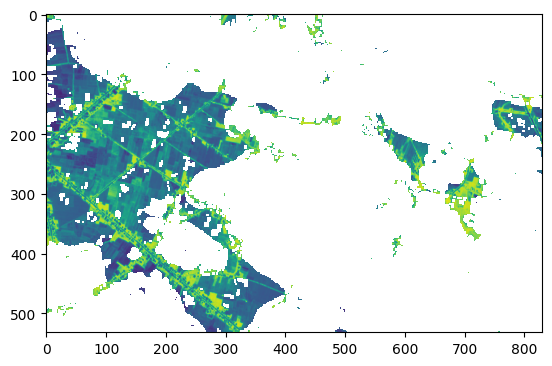

In [13]:
plt.imshow(average_ndvi.isel(time=0), vmin=None, vmax=None)
average_ndvi.shape

In [14]:
fill_nan_model = joblib.load('model_train/regressor/500points/fill_nan_model_gb.pkl')

In [15]:
mask = ~np.isnan(average_ndvi)

In [16]:
cloud_free_points = np.stack([average_vh.values[~mask], average_vv.values[~mask]], axis=1)

In [17]:
# X_pred = np.stack([average_vh.values[~mask], average_vv.values[~mask]], axis=1)
average_ndvi.values[~mask] = fill_nan_model.predict(cloud_free_points)
average_ndvi_filled = xr.DataArray(average_ndvi, dims=average_ndvi.dims)

In [29]:
print(average_ndvi.shape, average_vh.shape, average_vv.shape)

(13, 532, 830) (13, 532, 830) (13, 532, 830)


In [40]:
thuanhoa_path = "ThuanHoa/region/ST_ThuanHoa_Boundaryofficially.shp"

In [32]:
# load model RF

loaded_model = joblib.load(os.path.join("model_train/new/classify", "classify_srf.joblib"))

In [33]:
%time
# dự đoán
data_array = predict(loaded_model, data_sen2.rio.crs, average_ndvi, average_vh, average_vv)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.8 µs


In [34]:
# cấu hình màu cho các loại đất
colors = [
    "#abcee9",
    "#ffef44",
    "#c4ff9e",
    "#ffd6a8",
    "#93ddda",
    "#1aeef7",
    "#ffa7f2",
    "#33ee33"
]
labels = [
    "Lúa tôm",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]

/tmp/ipykernel_142/2294385133.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


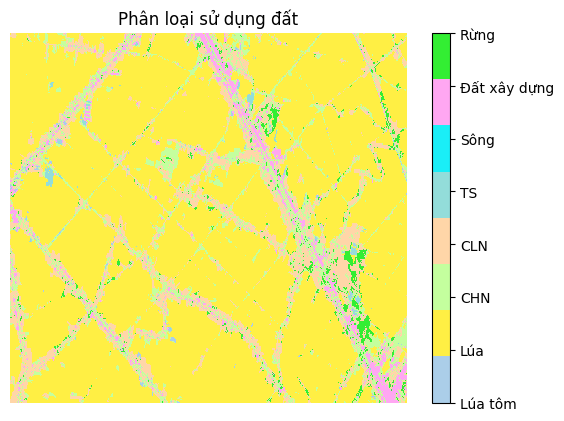

In [35]:
# hiển thị phân loại sử dụng đất
cmap = ListedColormap(colors)
img = data_array.plot(cmap=cmap, add_colorbar=False)
cbar = plt.colorbar(img)
cbar.ax.set_yticklabels(labels)
plt.title("Phân loại sử dụng đất")
plt.axis('off')
plt.show()

In [41]:
# cắt theo ranh giới xã thuận hòa
region_result = cut_according_shp(thuanhoa_path, average_ndvi, data_array)

/env/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:191: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [42]:
# hiển thị kết quả phân loại sử dụng đất
colorval = list(range(len(colors)))
options = {
    'title': 'Phân loại sử dụng đất',
    'cmap': colors,
    'clim': (0, 8),
    'aspect': 'equal',
    'colorbar_opts': {
        'major_label_overrides': dict(zip(colorval, labels)),
        'major_label_text_align': 'left',
        'ticker': FixedTicker(ticks=colorval),
    },
}
                                      
region_result.hvplot(
    rasterize = True,                        # Use Datashader, particularly useful for dask arrays
    aggregator = reductions.mode(),          # Datashader selects mode value, requires 'hv.Image'
).options(opts.Image(**options))

:DynamicMap   []
   :Image   [x,y]   (value)

In [43]:
# Lưu lại kết quả
region_result.rio.to_raster("classify_results/KetQuaPhanLoaiDat_svm.tif")

In [18]:
# đóng client, cluster
client.close()
cluster.close()